In [25]:
# imports
import os, base64, time, random, requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, Dataset, Subset
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold
from alibi_detect.cd.pytorch import HiddenOutput, preprocess_drift
from alibi_detect.cd import MMDDrift, MMDDriftOnline
from functools import partial

In [26]:
# TODO 
model_path = "/Users/manali/nyu/COURSES/Sem4/MLOps/ECE-GY-9183-Machine-Learning-Systems-Engg-Operations-Project/src/serving/inference_service/model.pth"  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path, map_location=device, weights_only=False)
_ = model.eval()  

In [27]:
# Preprocess Images
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = csv_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))
        if self.transform:
            image = self.transform(image)
        return image, label

def create_dataloaders(csv_file, img_dir, img_size=(224, 224), batch_size=32, n_fold=0):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip()
    ])

    dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    for i, (train_index, val_index) in enumerate(skf.split(np.zeros(len(csv_file)), csv_file.iloc[:, 1].values)):
        if i == n_fold:
            break

    train_dataset = Subset(dataset, train_index)
    dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir,
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.ToTensor()
                               ]))
    val_dataset = Subset(dataset, val_index)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader

In [28]:
val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip()
    ])

In [29]:
# @TODO: Change Paths
csv_file = pd.read_csv("/Users/manali/nyu/COURSES/Sem4/MLOps/serving/AiVsHuman/validation.csv")
img_dir="/Users/manali/nyu/COURSES/Sem4/MLOps/serving/AiVsHuman/Images"

In [30]:
# Load preprocessed data 
train_loader, val_loader = create_dataloaders(
        csv_file=csv_file,
        img_dir=img_dir,
        img_size=(224,224),
        batch_size=32,
        n_fold=0
    )

In [31]:
x_ref, y_ref = next(iter(train_loader))
print("x_ref shape:", x_ref.shape)

x_ref shape: torch.Size([32, 3, 224, 224])


In [32]:
x_new, y_new = next(iter(val_loader))
print("x_new shape:", x_new.shape)

x_new shape: torch.Size([32, 3, 224, 224])


In [33]:

# Use `HiddenOutput` from alibi_detect to extract features from the last layer of our classifier before the "head"
feature_model = HiddenOutput(model, layer=-1) 

# preprocess_drift defines the model used for drift detection - the HiddenOutput model
preprocess_fn = partial(preprocess_drift, model=feature_model, batch_size=128)

# Create an MMD-based change detector, where:
#  - x_ref is reference data to describe what input to the classifier head *should* look like
#  - preprocess_fn will be used to extract features from both reference and test data,
#  - the backend is PyTorch (Tensorflow is also supported)
#  - p_val = 0.05 means we consider the difference between reference and test data to be significant at 95% confidence
cd = MMDDrift(x_ref, backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn)
     

No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


In [34]:
x_tr, y_tr = next(iter(train_loader))
cd_preds = cd.predict(x_tr)
cd_preds

No GPU detected, fall back on CPU.


{'data': {'is_drift': 0,
  'distance': -0.0035251379013061523,
  'p_val': 0.5,
  'threshold': 0.05,
  'distance_threshold': array(0.02365059, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.12.0',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

In [35]:
preprocess_fn = partial(preprocess_drift, model=feature_model)

cd_online = MMDDriftOnline(
    x_ref,           # reference embeddings
    ert=300,         # expected run time between false positives (larger = fewer false alarms)
    window_size=10,  # how many test samples to use in each MMD check
    backend='pytorch',
    preprocess_fn=preprocess_fn
)

No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Generating permutations of kernel matrix..


Computing thresholds: 100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.33it/s]


In [36]:
results = []
x_new, y_new = next(iter(val_loader))  # one batch
for x in x_new:
    cd_pred = cd_online.predict(x.cpu().numpy())
    results.append(cd_pred['data'])

No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fal

In [37]:
print([r['is_drift'] for r in results])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


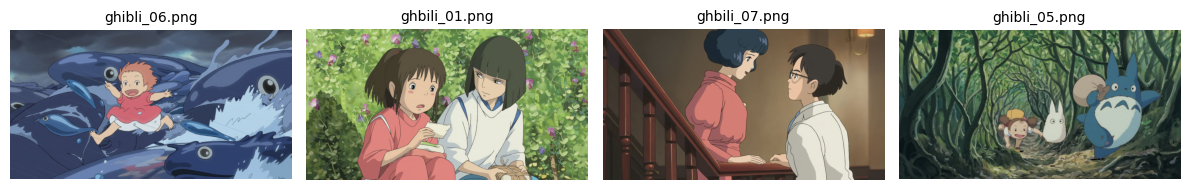

In [38]:
image_dir = "ghibli/"
image_files = [
    f for f in os.listdir(image_dir)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

num_images = 16
sample_files = random.sample(image_files, min(num_images, len(image_files)))

cols = 4
rows = (len(sample_files) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for ax, filename in zip(axes.flatten(), sample_files):
    image_path = os.path.join(image_dir, filename)
    img = Image.open(image_path).convert("RGB")
    ax.imshow(img)
    ax.set_title(filename, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [39]:
results_ai = []
sample_files = random.sample(image_files, min(32, len(image_files)))
for filename in sample_files:
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path).convert("RGB")
    x_tensor = val_test_transform(image)  # shape: [3, 224, 224]
    x_np = x_tensor.numpy()
    cd_pred = cd_online.predict(x_np)
    results_ai.append(cd_pred['data'])

No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


In [40]:
print([r['is_drift'] for r in results_ai])

[0, 0, 0, 0]


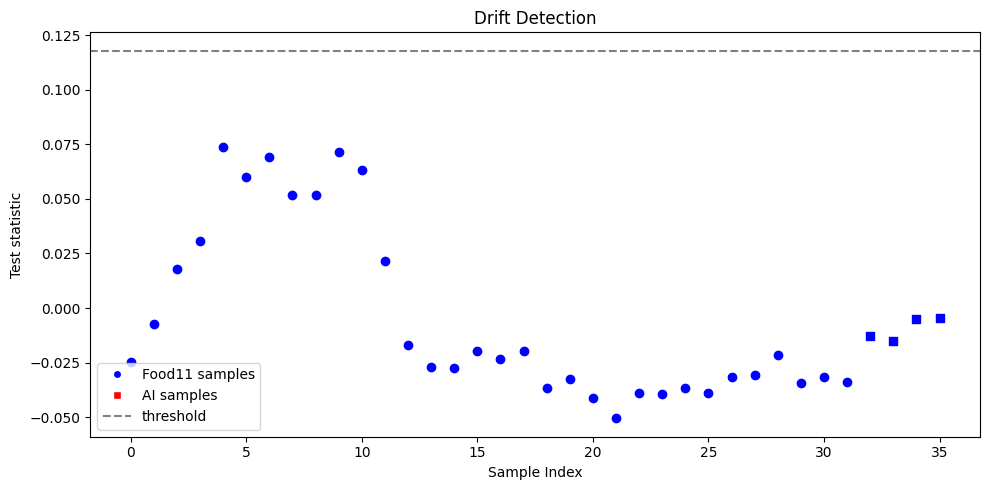

In [41]:
import matplotlib.pyplot as plt

test_stats = [r['test_stat'] for r in results[:32]]
drift_flags = [r['is_drift'] for r in results[:32]]

test_stats_ai = [r['test_stat'] for r in results_ai[:32]]
drift_flags_ai = [r['is_drift'] for r in results_ai[:32]]

combined_stats = test_stats + test_stats_ai
combined_flags = drift_flags + drift_flags_ai
combined_labels = ['regular'] * len(test_stats) + ['ai'] * len(test_stats_ai)

plt.figure(figsize=(10, 5))
for i, (stat, drift, label) in enumerate(zip(combined_stats, combined_flags, combined_labels)):
    color = 'red' if drift else 'blue'
    marker = 'o' if label == 'regular' else 's'
    plt.scatter(i, stat, color=color, marker=marker)

threshold = results[0]['threshold'] if results else results_ai[0]['threshold']
plt.axhline(y=threshold, linestyle='--', color='gray')

plt.title("Drift Detection")
plt.xlabel("Sample Index")
plt.ylabel("Test statistic")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Food11 samples', markerfacecolor='blue'),
    plt.Line2D([0], [0], marker='s', color='w', label='AI samples', markerfacecolor='red'),
    plt.Line2D([0], [0], color='gray', linestyle='--', label='threshold')
])
plt.tight_layout()
plt.show()

In [42]:
from alibi_detect.saving import save_detector
cd_online.reset_state()
save_detector(cd_online, "cd")
     

# Test by sending Ghibli images

In [48]:
!pip install datasets
from datasets import load_dataset
ds = load_dataset("Nechintosh/ghibli")

  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 37.9 MB/s eta 0:00:00 MB/s eta 0:00:0101
  Attempting uninstall: fsspec38;5;237m╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/13 [pyarrow]
    Found existing installation: fsspec 2025.3.237m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/13 [pyarrow]
    Uninstalling fsspec-2025.3.2:7m╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/13 [pyarrow]
      Successfully uninstalled fsspec-2025.3.2;237m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/13 [pyarrow]
  Attempting uninstall: dill;5;237m╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/13 [pyarrow]
    Found existing installation: dill 0.3.98;5;237m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/13 [pyarrow]
    Uninstalling dill-0.3.9:━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━  6/13 [dill]
      Successfully uninstalled dill-0.3.938;5;237m╺━━━━━━━━━━━━━━━━━━━━━  6/13 [dill]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [datasets]237m━━━ 12/13 [datasets]


Generating train split: 100%|██████████████████████████████████| 810/810 [00:00<00:00, 42194.12 examples/s]


In [45]:
# data_dir = "/Users/manali/nyu/COURSES/Sem4/MLOps/ECE-GY-9183-Machine-Learning-Systems-Engg-Operations-Project/src/serving/ghibli"
# test_dataset = datasets.ImageFolder(data_dir)
# image_paths = [sample[0] for sample in test_dataset.samples]
# random.shuffle(image_paths)

# FASTAPI_URL = "http://localhost:8000/predict"

# for image_path in image_paths:
#     with open(image_path, 'rb') as f:
#         image_bytes = f.read()
#     encoded_str = base64.b64encode(image_bytes).decode("utf-8")
#     payload = {"image": encoded_str}
#     response = requests.post(FASTAPI_URL, json=payload)

In [49]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'caption'],
        num_rows: 810
    })
})

In [52]:
import base64
import requests
from io import BytesIO
import random

# Shuffle the dataset (optional, since it's already in memory)
train_dataset = ds["train"]
indices = list(range(len(train_dataset)))
random.shuffle(indices)

FASTAPI_URL = "http://localhost:8000/predict"

for idx in indices:
    sample = train_dataset[idx]
    image = sample["image"]  # This is likely a PIL Image

    # Convert the image to bytes
    buffered = BytesIO()
    image.save(buffered, format="PNG")  # You can use "JPEG" if preferred
    image_bytes = buffered.getvalue()

    # Encode in base64
    encoded_str = base64.b64encode(image_bytes).decode("utf-8")

    # Send the request
    payload = {"image": encoded_str}
    response = requests.post(FASTAPI_URL, json=payload)

    print(response.status_code, response.json())


200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 0.9999997615814209}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 0.9999346733093262}
200 {'prediction': 'Human', 'probability': 0.9999998807907104}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 1.0}
200 {'prediction': 'Human', 'probability': 